# Data Science Workshop

# Data Loading

## Import Python Libraries

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

import random

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

# read the entire file into a python array
with open('raw_data.json', 'rb') as f:
    data = f.readlines()
with open('new_photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('new_feeds.json', 'rb') as f:
    feeds_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='inner', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y'], axis=1, inplace=True)

# Data preparation

# currentLocation and current_location are too sparse and it's not clear if its a city/country etc..
ready_feats = ['has_cover_photo', 'has_profile_photo', 'id', 'likes', 

               # photo fields
               'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
               'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
               'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
               'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
               'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
               'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
               'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
               'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
               # feed fields
               'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
               'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
               'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
               'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
               'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
               'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
               'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
               'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
               'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
               'post_count',
               
               
#                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
#                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 'feed_avg_shares_cnt', 
#                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
#                'feed_count_post_updated', 'feed_is_hidden_count', 'feed_is_published_count', 
#                'feed_max_comments', 'feed_max_likes', 'feed_max_shares', 'feed_max_shares_cnt', 
#                'feed_min_comments', 'feed_min_likes', 'feed_min_shares', 'feed_min_shares_cnt', 
#                'feed_number_of_added_photos_posts', 'feed_number_of_days_between_first_and_last_posts', 
#                'feed_number_of_different_months_for_post', 'feed_number_of_null_albums', 'feed_number_of_other_posts', 
#                'feed_number_of_shared_story_posts', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
#                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_std_shares', 'feed_std_shares_cnt', 
#                'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count', 'post_count'              
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['count_has_name'] = all_data.apply(lambda x: x['count_has_name']/x['total_photos'] if x['count_has_name'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['count_has_place'] = all_data.apply(lambda x: x['count_has_place']/x['total_photos'] if x['count_has_place'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['distinct_uploaders'] = all_data.apply(lambda x: x['distinct_uploaders']/x['total_photos'] if x['distinct_uploaders'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum()
print missing_count[missing_count.nonzero()[0]]

# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'feed_avg_comments', 'feed_avg_likes', 
                    'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_with_tagged_per_post_with_more_than_zero',
                    'feed_max_comments', 'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_std_comments', 
                    'feed_std_likes', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares', 'price_range',
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)

val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 100 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

## Types Conversion

binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 'is_permanently_closed', 'is_unclaimed', 'is_verified']
categorical_variables = ['country', 'price_range']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
# TODO - rename bins by min-max vals
#     df = DataFrame()
#     df['col'] = col
#     df['bins'] = colBin
#     grouped = df['col'].groupby('bins')
    
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n):
    plt.title('Confusion Matrix Image')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
    
def print_ds_fields(ds):
    for feat in ds.columns.get_values():
        print "%s\t%s\t%s" % (ds.columns.get_loc(feat), ds.dtypes[ds.columns.get_loc(feat)], feat)
        
    missing_count = ds.isnull().sum()
    print "cols with missing values (%s cols):" % len(missing_count.nonzero()[0])
    print missing_count[missing_count.nonzero()[0]]

    
    for feat in ds.columns.get_values():
        t = ds[feat].apply(lambda x: 1 if not np.isfinite(x) else 0)
        if t.sum() > 0:
            print feat, t.sum()


## Drop unnecessary columns

# Data Exploration

#  Data cleaning

## Remove Outliers

In [117]:
filtered_all_data = all_data.copy()
filtered_all_data = filtered_all_data[filtered_all_data['is_permanently_closed'] != 1].reset_index(drop=True)
filtered_all_data.drop('is_permanently_closed', axis = 1,  inplace=True)

filtered_all_data.head(5)

normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
                        'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
                        'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
                        'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
                        'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
                        'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
                        'feed_avg_with_tagged_per_post', 
                        'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
                        'feed_max_likes', 'feed_max_shares', 'feed_min_comments', 
                        'feed_min_likes', 'feed_min_shares', 
                        'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 'likes']
temp2 = filtered_all_data.copy()
tot = 0
for feat in normal_by_min_max:
    temp = filtered_all_data[abs(filtered_all_data[feat] - filtered_all_data[feat].mean()) <= 3*filtered_all_data[feat].std()]
    temp2 = temp2[abs(temp2[feat] - temp2[feat].mean()) <= 3*temp2[feat].std()]
    tot += filtered_all_data.id.count() - temp.id.count()
    print "feat: %s, leaves %s samples (%s removed)" % (feat, temp.id.count(), filtered_all_data.id.count() - temp.id.count())

print tot
print "final - %s samples left" % temp2.id.count()

filtered_all_data = temp2.copy()

,has_cover_photo,has_profile_photo,id,likes,photo_avg_comments_per_photo,photo_avg_likes_per_comments,photo_avg_likes_per_photo,photo_avg_people_tagged_per_photo,photo_avg_people_tagged_per_photo_with_more_than_zero,photo_count_has_name,...,has_phone,has_website,has_location,has_description,has_general_info,has_products,name_num_of_words,photo_upload_freq,feed_update_freq,country
0,1,1,109626372391961,13311,3.25,1.50,2.50,0.00,0.00,1,...,1,1,1,True,False,False,1,3,0,Canada
1,1,1,834585939923334,16361,1.77,0.69,55.69,0.00,0.00,10,...,1,1,1,True,False,False,2,29,0,other
2,1,1,10150149049510092,6947,1.43,0.70,13.48,1.35,1.94,2,...,1,1,1,True,False,True,1,2,0,other
3,1,1,57843015021,227009,21.68,8.44,134.05,0.97,4.06,40,...,1,1,1,True,False,False,2,42,0,United Kingdom
4,1,1,226269077569044,288531,13.00,10.92,338.11,0.01,1.00,71,...,1,1,1,False,False,False,2,11,0,United States


In [119]:
normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_null_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_null_albums', 'total_photos'],
                                ['photo_number_of_photos_in_other_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['photo_distinct_uploaders', 'total_photos'],
                                ['feed_count_has_place', 'post_count'],
                                ['feed_count_post_updated', 'post_count'],
                                ['feed_is_published_count', 'post_count'],
                                ['feed_number_of_added_photos_category', 'post_count'],
                                ['feed_number_of_different_months_for_post', 'post_count'],
                                ['feed_number_of_null_category', 'post_count'],
                                ['feed_number_of_other_categories', 'post_count'],
                                ['feed_number_of_shared_story_category', 'post_count']
                             ]

for feat in normal_by_total_count_vars: 
    filtered_all_data[feat[0]] = filtered_all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)

# normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
#                         'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
#                         'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
#                         'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
#                         'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
#                         'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
#                         'feed_avg_with_tagged_per_post', 
#                         'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
#                         'feed_max_likes', 'feed_max_shares', 'feed_min_comments', 
#                         'feed_min_likes', 'feed_min_shares', 
#                         'feed_post_max_people_tagged', 'feed_post_max_with_tagged']

# filtered_all_data[normal_by_min_max] = filtered_all_data[normal_by_min_max].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0, axis=1)
# # filtered_all_data[normal_by_min_max] = preprocessing.robust_scale(filtered_all_data[normal_by_min_max])

# filtered_all_data[normal_by_min_max + [f[0] for f in normal_by_total_count_vars]].head(5)

# Models

## Utils

## Preprocessing

### dummies variables 

In [120]:
# change back empty and 0 to NaN before converting to dummy variables
country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, country_dv, price_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape


### Convert likes count to bins and print bin details

train_len = int(len(pp_data['id']) * 0.8)
bin_num = 4
pp_data['labels'] = binning(pp_data['likes'], bin_num)

bin_data = pp_data.groupby('labels')['likes'].describe()
print bin_data
bin_names = ['BIN_0', 'BIN_1', 'BIN_2'] 
seperators = [bin_data[bin_name]['max'] for bin_name in bin_names]

shape before dummy vars:  (8873, 75)
shape after dummy vars:  (8873, 102)


## Logistic Regression

In [ ]:
# from sklearn import (cross_validation, feature_selection, pipeline,
#                      preprocessing, linear_model, grid_search)
# lr_train_len = train_len
# lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_ids = pp_data['id']
# lr_data_set = pp_data.copy()
# lr_data_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# folds = 5
# split = cross_validation.StratifiedKFold(lr_labels, n_folds=folds, shuffle = False, random_state = 0)

# scores = []
# for k, (train, test) in enumerate(split):

#     X_train, X_test, y_train, y_test = lr_data_set.ix[train], lr_data_set.ix[test], lr_labels.ix[train], lr_labels.ix[test]

#     top_feat = feature_selection.SelectKBest()

#     pipe = pipeline.Pipeline([('feat', top_feat),
#                               ('clf', linear_model.LogisticRegression())])

#     K = [40, 60, 80, 100]
#     C = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#     penalty = ['l1', 'l2']

#     param_grid = [{'feat__k': K,
#                   'clf__C': C,
#                   'clf__penalty': penalty}]

#     scoring = 'precision'

#     gs = grid_search.GridSearchCV(estimator=pipe, param_grid = param_grid, scoring = scoring)
#     gs.fit(X_train, y_train)

#     best_score = gs.best_score_
#     scores.append(best_score)

#     print "Fold: {} {} {:.4f}".format(k+1, scoring, best_score)
#     print gs.best_params_

In [108]:

lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

lr_selceted_c = 0.01

print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)
sfm = SelectFromModel(lr)

new = sfm.fit_transform(lr_train_set, lr_train_labels)

for feat in lr_train_set.columns.get_values():
    if sfm.get_support()[lr_train_set.columns.get_loc(feat)]:
        print "%s\t%s" % (lr_train_set.columns.get_loc(feat), feat)

        

# print lr.score(lr_train_set, lr_train_labels)
# print lr.score(lr_test_set, lr_test_labels)

new_test = sfm.transform(lr_test_set)
lr.fit(new, lr_train_labels)

print lr.score(new, lr_train_labels)
print lr.score(new_test, lr_test_labels)

# fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
# lr_auc = metrics.auc(fpr, tpr)
# print "logistic regression train set auc:", lr_auc
# plotRoc(fpr, tpr, lr_auc)
# print "calculating logistic regression Performance on the test set - multi class:"
# print(metrics.classification_report(lr_test_labels, lr_test_predictions))
# plotMetrics(lr_test_labels,lr_test_predicted_probs)


training logistic regression
1	has_profile_photo
6	photo_avg_people_tagged_per_photo_with_more_than_zero
7	photo_count_has_name
13	photo_number_of_albums
17	photo_number_of_other_albums
20	photo_number_of_photos_in_other_albums
27	feed_avg_likes_per_comment
29	feed_avg_people_tagged_per_post_with_more_than_zero
35	feed_is_published_count
39	feed_min_likes
45	feed_post_max_people_tagged
47	feed_post_updated_prc
54	feed_min_shares
58	is_verified
62	has_phone
63	has_website
64	has_location
65	has_description
67	has_products
68	name_num_of_words
76	country_Egypt
79	country_India
88	country_Philippines
93	country_United States
96	price_range_1.0
97	price_range_2.0
0.735841081995
0.800563380282


C=1e-05: 0.884087868333
C=0.0001: 0.886900506797
C=0.001: 0.888239712685
C=0.01: 0.89017734622
C=0.1: 0.889610303113
C=1.0: 0.889456369805


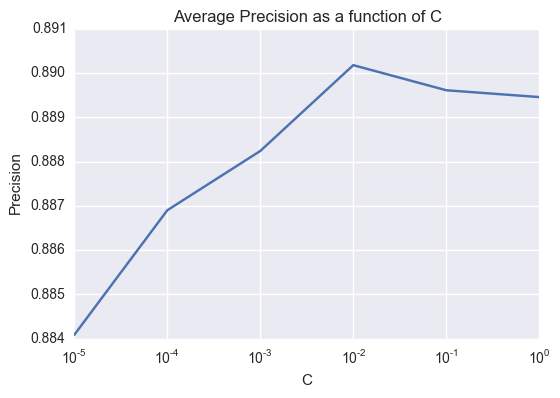

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.895973112289
calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.82      0.60      0.69       625
          1       0.81      0.93      0.86      1150

avg / total       0.81      0.81      0.80      1775

C=1e-05: 0.842824643486
C=0.0001: 0.848873038589
C=0.001: 0.856074054198
C=0.01: 0.85943716378
C=0.1: 0.864510045756
C=1.0: 0.861576530358


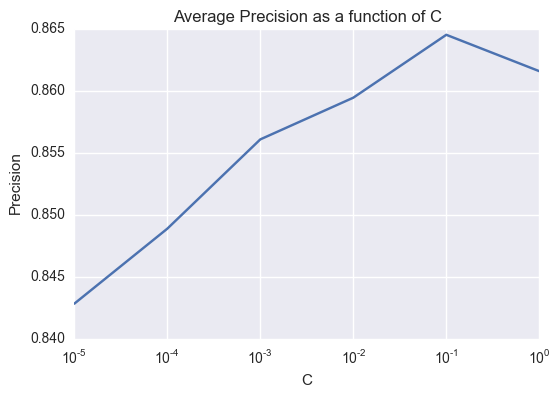

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.860779784652
calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.83      0.84      0.84      1072
          1       0.76      0.75      0.75       703

avg / total       0.80      0.80      0.80      1775

C=1e-05: 0.834183369341
C=0.0001: 0.842389228792
C=0.001: 0.856315171223
C=0.01: 0.870464192033
C=0.1: 0.876350967704
C=1.0: 0.871217904052


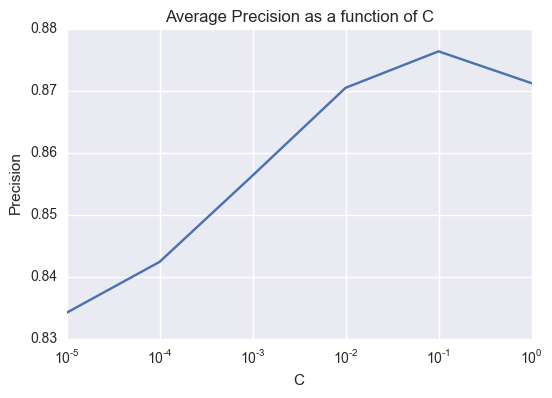

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.864705172551
calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.88      0.96      0.92      1396
          1       0.77      0.52      0.62       379

avg / total       0.86      0.86      0.85      1775



In [113]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_test_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_test_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_test_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_test_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-5,0, num=6)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='roc_auc')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_test_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
#     plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_test_labels, lr_test_predictions))
#     plotMetrics(lr_test_labels,lr_test_predicted_probs)


Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 1 values determined by higher probability, 0 by probability sum, 8872 were definitive


ALL DATA:
[[1238  873  102    6]
 [ 316 1207  645   50]
 [ 111  726 1101  280]
 [  32  231  761 1194]]


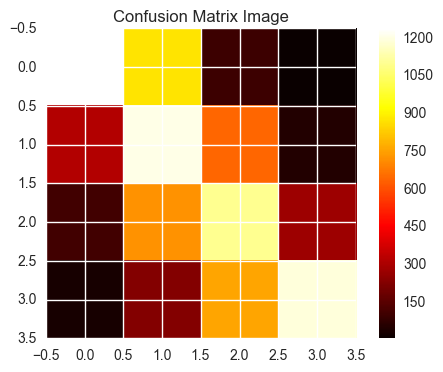

TEST SET ONLY:
[[373 227  23   2]
 [ 53 250 135   9]
 [ 17 105 155  47]
 [ 12  45 126 196]]


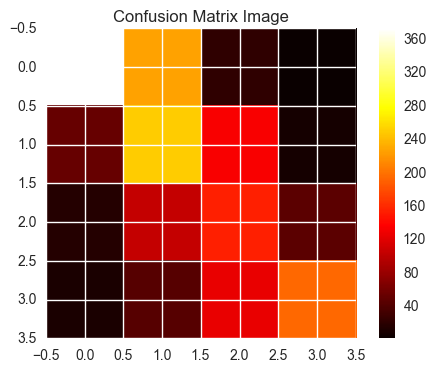

train score: 0.57790728112
train score: 0.53057199211
test score: 0.585808254216
test score: 0.548732394366


In [114]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

prediction_cols = ['lr_prediction_BIN_0', 'lr_prediction_BIN_1', 'lr_prediction_BIN_2', 'lr_prediction_proba_BIN_0', 'lr_prediction_proba_BIN_1', 'lr_prediction_proba_BIN_2']


4
0


IndexError: index 0 is out of bounds for axis 1 with size 0

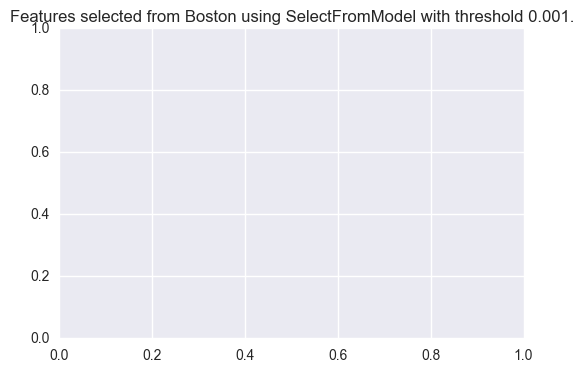

In [106]:
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# sfm = SelectFromModel(lm.LassoCV())
# sfm.fit(lr_train_set, lr_train_labels)
# n_features = sfm.transform(lr_train_set).shape[1]
# print n_features

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.001
#     X_transform = sfm.transform(lr_train_set)
#     n_features = X_transform.shape[1]
#     print n_features

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

### Preprocessing

In [36]:
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.866633983332
C=1e-11: 0.879851560951
C=1e-10: 0.883927165336
C=1e-09: 0.890033280944
C=1e-08: 0.888102944427
C=1e-07: 0.893298975005
C=1e-06: 0.902186580893
C=1e-05: 0.904886141368


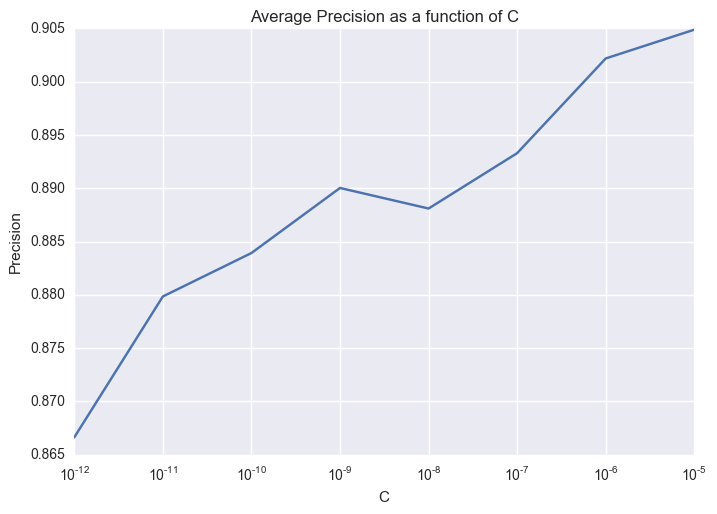

In [37]:
cv_scores = []
space = np.logspace(-10,-2, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.883927165336
C=2.15443469003e-10: 0.887292982014
C=4.64158883361e-10: 0.889880287287
C=1e-09: 0.890033280944
C=2.15443469003e-09: 0.889221849537
C=4.64158883361e-09: 0.888324973356
C=1e-08: 0.888102944265


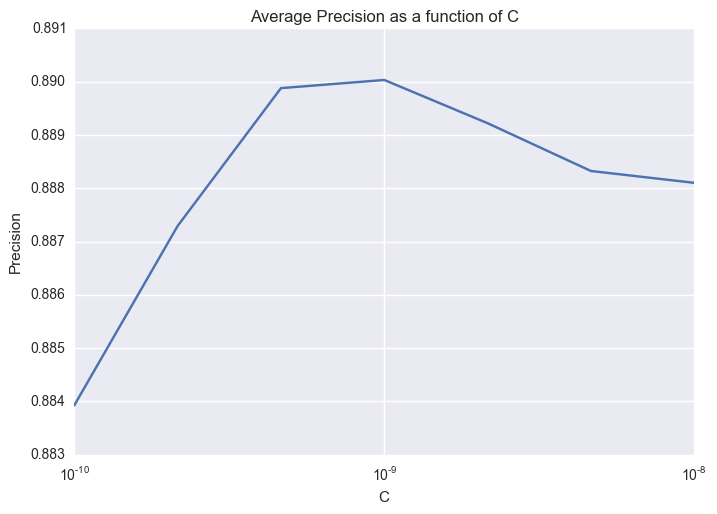

In [38]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:
logistic regression train set auc: 0.865343621882


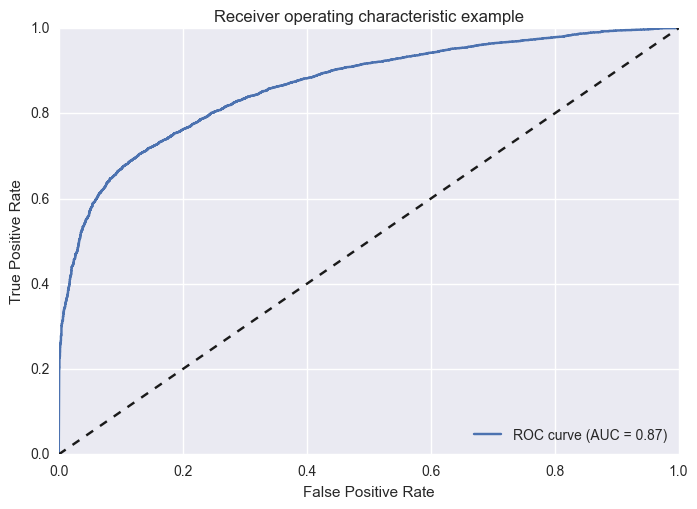

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1506
          1       0.84      0.63      0.72      1059

avg / total       0.81      0.80      0.79      2565



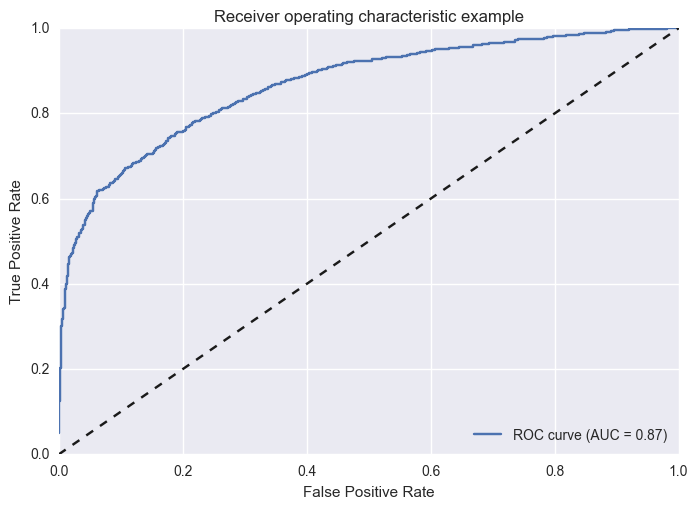

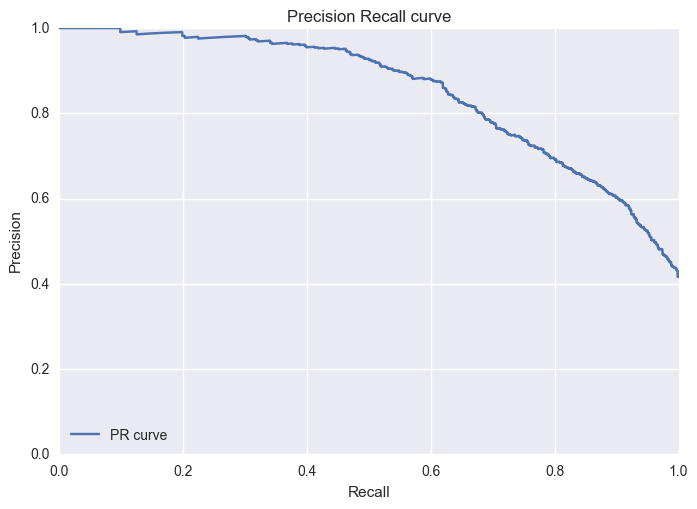

In [39]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_test_predictions = lr_predictions[lr_train_len:]

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr_predictions.copy()

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)

# pected = test_class.values
# oh_test_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_test_data)
# predicted_probs = logreg.predict_proba(oh_test_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# test_set['logistic_regression_prediction'] = lr_test_predictions

## SVM

### Preprocessing

In [40]:
svm_pp_data = pp_data.copy()
svm_train_len = train_len
svm_test_len = int(len(pp_data['id'])) - train_len
# svm_pp_data.drop(categorical_variables, 1, inplace=True)

svm_labels = svm_pp_data['likes'].apply(lambda x: 0 if x < seperator else 1)
svm_ids = svm_pp_data['id']

svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_test_set = svm_pp_data[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_test_labels = svm_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_test_ids = svm_ids[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_set = svm_train_set.append(svm_test_set, ignore_index=True)

### Parameter optimization 

C=1e-05: 0.527208519529
C=0.0001: 0.530358758403
C=0.001: 0.532842925863
C=0.01: 0.534132758145
C=0.1: 0.535914847971
C=1: 0.543450087451
C=10: 0.543853211037
C=100: 0.543853211037


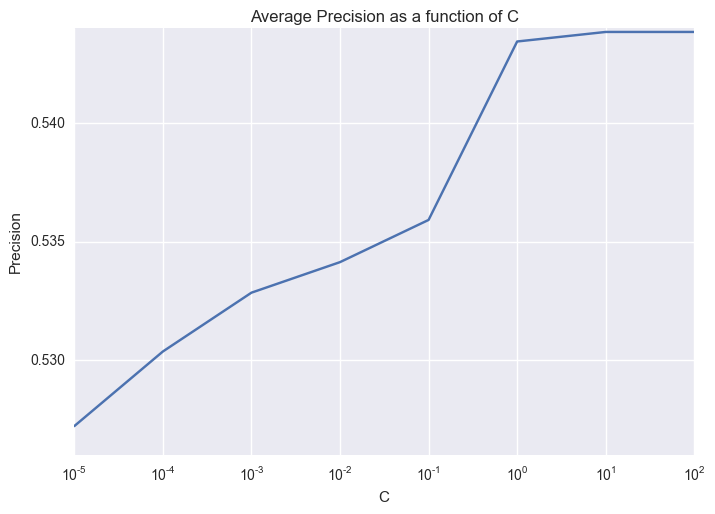

In [42]:
cv_scores = []
cs = []
for c in range(-5,3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

### SVM run

In [518]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)
svm_model.fit(pp_train_set, pp_train_labels)
svm_train_prediction = svm_model.predict_proba(pp_train_set)
svm_test_prediction = svm_model.predict_proba(pp_test_set)

fpr, tpr, thresholds = metrics.roc_curve(pp_train_labels, svm_train_prediction[:,1])
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc

plotRoc(fpr, tpr, svm_train_auc)

(6689, 191)

## Random Forest

### Preprocessing

In [122]:
rf_train_len = train_len
rf_labels = pp_data['labels']
rf_ids = pp_data['id']

rf_train_set = pp_data[:rf_train_len].copy()
rf_test_set = pp_data[rf_train_len:].copy()


rf_train_ids = rf_ids[:rf_train_len].copy()
rf_test_ids = rf_ids[rf_train_len:].copy()

rf_train_labels = rf_labels[:rf_train_len].copy()
rf_test_labels = rf_labels[rf_train_len:].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)



### Parameter optimization

Feature ranking - Top 10:
1. feature 59 (talking_about_count)
   score: 0.083431
2. feature 26 (feed_avg_likes)
   score: 0.051956
3. feature 37 (feed_max_likes)
   score: 0.046413
4. feature 30 (feed_number_of_days_between_first_and_last_posts)
   score: 0.045365
5. feature 49 (feed_std_likes)
   score: 0.045333
6. feature 10 (photo_max_like)
   score: 0.043458
7. feature 24 (photo_number_of_days_between_first_and_last_photos)
   score: 0.041132
8. feature 23 (total_photos)
   score: 0.040242
9. feature 4 (photo_avg_likes_per_photo)
   score: 0.036338
10. feature 25 (feed_avg_comments)
   score: 0.032298


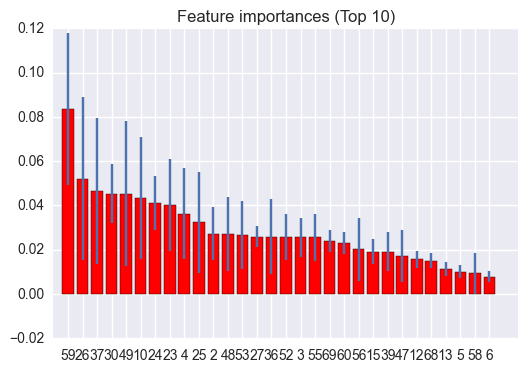

In [123]:
forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(10):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:30]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.bar(range(30), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(30), plot_idxs)
plt.xlim([-1, 31])
plt.show()

In [124]:
importances_thresholds = [0, 0.01] #[0, 0.01, 0.02, 0.03, 0.04]
max_depths = [15, None] #[10, 20, 30, None]
min_samples_leaf = [1] #[1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
print "(threshold, depth, min_samples) -> average precision score"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set, rf_train_labels)
            temp_predictions = forest.predict(rf_test_set)
            res = metrics.precision_score(rf_test_labels, temp_predictions, average='macro')
            score_summary.append(res)
            params.append((importances_thresholds[i], d, l))
            print "%s -> %s" % (params[-1], score_summary[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score
(0, 15, 1) -> 0.619424994133
(0, None, 1) -> 0.609534026303
(0.01, 15, 1) -> 0.619424994133
(0.01, None, 1) -> 0.609534026303
RF best parameters:
max_depth =  15
importance_threshold =  0
min_samples_leaf =  1


### RF running

Random Forest test precision: 0.61939680647
[[506 112   7   0]
 [119 214 105   9]
 [ 22  90 149  63]
 [ 18  26  72 263]]


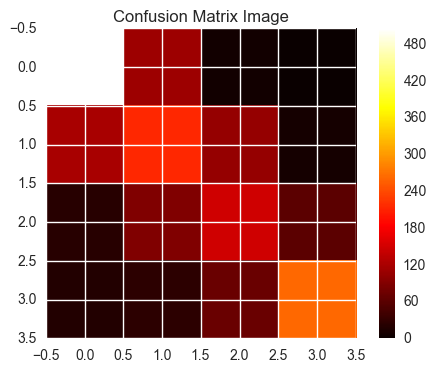

In [125]:
fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_test_predicted_probs = forest.predict_proba(rf_test_set[fc])
rf_test_predictions = forest.predict(rf_test_set[fc])
res = metrics.precision_score(rf_test_labels, rf_test_predictions, average='macro')
print "Random Forest test precision:", res

cm_rf_labels = rf_test_labels.apply(lambda x: x[-1])
cm_rf_predictions = [a[-1] for a in rf_test_predictions.tolist()]
m = confusion_matrix(cm_rf_labels.values, cm_rf_predictions)
print m
plotConfusion(m, bin_num)

## LR - numrical predictions - DELETE ME

In [61]:
lr2_pp_data = all_data.copy()
lr2_pp_data.drop(categorical_variables, 1, inplace=True)
lr2_pp_data = lr2_pp_data[lr2_pp_data['likes'] > 50000]
lr2_pp_data = lr2_pp_data.sample(frac=1)

lr2_train_len = 1000
lr2_test_len = 100
lr2_labels = pp_data['likes']
lr2_ids = pp_data['id']

lr2_train_set = pp_data[:lr2_train_len].copy()
lr2_test_set = pp_data[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_labels = lr2_labels[:lr2_train_len].copy()
lr2_test_labels = lr2_labels[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_ids = lr2_ids[:lr2_train_len].copy()
lr2_test_ids = lr2_ids[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_set.drop(['likes', 'id'], 1, inplace=True)
lr2_test_set.drop(['likes', 'id'], 1, inplace=True)
lr2_set = lr2_train_set.append(lr2_test_set, ignore_index=True)

In [62]:
lr2 = lm.LogisticRegression(penalty='l1', C=10**(-3))  #penalty='l2' #dual=True) #lr_selceted_c)

print "training logistic regression"
lr2.fit(lr2_train_set, lr2_train_labels)

print "getting logistic regression predictions"
lr2_predictions = lr2.predict(lr2_set)

print "calculating logistic regression Performance on the test set:"
lr2.score(lr2_test_set, lr2_test_labels, sample_weight=None)

# lr2_train_predicted_probs = lr2_predicted_probs[:lr_train_len]
# lr2_test_predicted_probs = lr2_predicted_probs[lr_train_len:]

# lr2_train_predictions = lr2_predictions[:lr_train_len]
# lr2_test_predictions = lr2_predictions[lr_train_len:]

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the test set:


0.0

In [63]:
predicted = lr2_predictions[lr2_train_len:]
actual = lr2_test_labels.values
ratio = np.divide(predicted * 1.0, actual)

print 'median: ', np.median(ratio)
print 'mean: ', ratio.mean()
print 'std: ', ratio.std()
print 'min: ', ratio.min()
print 'max: ', ratio.max()


median:  1.3370815948
mean:  1.61211175502
std:  1.40803569521
min:  0.0
max:  7.02683595441


<function matplotlib.pyplot.show>

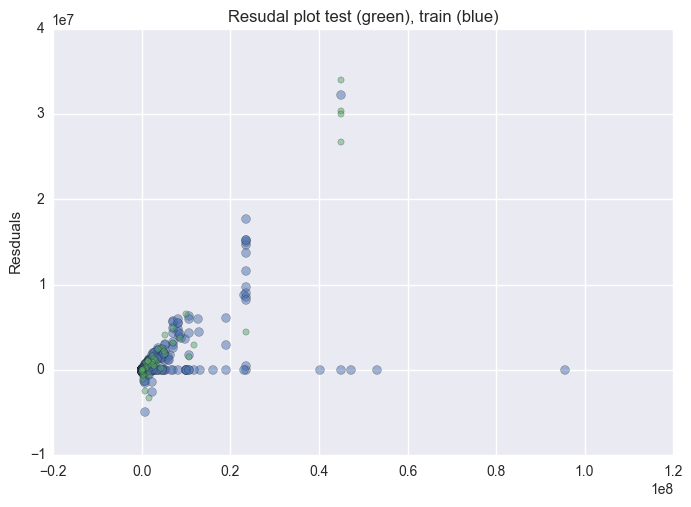

In [65]:
#TODO: add scatter plot predicted vs actual

plt.scatter(lr2_predictions[:lr2_train_len], lr2_predictions[:lr2_train_len] -  lr2_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lr2_predictions[lr2_train_len:], lr2_predictions[lr2_train_len:] -  lr2_test_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=50)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show